# Dataset Merge IDEA

1. history에 대해 drop duplicate 후 drop column      
2. watch 에 대해서도 drop duplicate 후 drop column     
3. 이후 inner join       
4. 다른 dataset merge   

문제 : 3번부터 램이 터져나감    
대안 1. 나눠서 조인 (노가다...)   
대안 2. 더 나은 노트북 환경 찾기   
대안 3. 똑똑하게 머리 쓰기 **<해결 방안 찾아냄>**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
history = pd.read_csv('../../data/history_data.csv')
history.drop_duplicates(subset=['profile_id','log_time','album_id'],inplace=True) 
# row = 1005651 rows × 8 columns
# after drop duplicates 899021 rows × 8 columns
# 106630 개 row 중복

### Watch에 대해서도 동일한 작업 수행 (duplicate drop, feature selection)

In [3]:
watch = pd.read_csv('../../data/watch_e_data.csv')
watch.drop_duplicates(subset=['profile_id','log_time','album_id'],inplace=True) 
# watch.drop(labels=['log_time','act_target_dtl'],axis=1,inplace=True)  # column 드랍. 따로 처리할 결측치 없음

In [4]:
# data preprocessing
# history에만 있는 profile_id  Length: 8311 / watch에만 있는 profile_id  Length: 7658
m_his = history['profile_id'].drop_duplicates() # 터짐 방지로 profile_id column만 남김 
m_wat = watch['profile_id'].drop_duplicates()
id_only_in_history = pd.merge(m_his,m_wat,how='outer',indicator=True
                ).query('_merge == "left_only"').drop(columns=['_merge'])
id_only_in_history_list = id_only_in_history['profile_id'].to_list()
id_only_in_history_rows = history[history['profile_id'].isin(id_only_in_history_list)]
id_only_in_history_rows = id_only_in_history_rows.drop_duplicates(subset=['profile_id','ss_id','log_time','album_id']) # 15241 rows
id_only_in_history_rows.drop(columns=['continuous_play','short_trailer'])
dataset = watch.append(id_only_in_history_rows,sort=False).sort_values('log_time').reset_index(drop=True)

/var/folders/wz/2dv1p69j3pv2c66bj9jt_hbc0000gn/T/ipykernel_14149/2297796919.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = watch.append(id_only_in_history_rows,sort=False).sort_values('log_time').reset_index(drop=True)


In [5]:
dataset.to_csv('./dataset.csv') 
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 815873 entries, 0 to 815872
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   profile_id       815873 non-null  int64  
 1   ss_id            815873 non-null  int64  
 2   log_time         815873 non-null  int64  
 3   act_target_dtl   815873 non-null  object 
 4   album_id         815873 non-null  int64  
 5   watch_time       800632 non-null  float64
 6   total_time       800632 non-null  float64
 7   continuous_play  815873 non-null  object 
 8   payment          564 non-null     float64
 9   short_trailer    15241 non-null   object 
dtypes: float64(3), int64(4), object(3)
memory usage: 62.2+ MB


# Meta Data merge 

In [6]:
# # 메타데이터 병합 
meta = pd.read_csv('../../data/meta_data.csv') # 42602 rows
meta_p = pd.read_csv('../../data/meta_data_plus.csv') # 767948 rows
# meta_merge = pd.merge(meta,meta_p,how='inner',on='album_id') #### meta 정보 최종 집합체 : 832356 rows
# data_w_meta = pd.merge(dataset,meta,how='inner',on='album_id')

/var/folders/wz/2dv1p69j3pv2c66bj9jt_hbc0000gn/T/ipykernel_14149/1435218993.py:2: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  meta = pd.read_csv('../../data/meta_data.csv') # 42602 rows


## Meta_plus 데이터 proprocess 

In [7]:
meta_p['keyword_type'].nunique()

1101

In [8]:
pd.set_option('display.max_rows',500)
# meta_p['keyword_name'].value_counts() # 1개 키워드 개수는 30개 가량뿐이다. 일단 keyword를 신뢰할 만하다고 판단.

# 한편, 아주 비슷한 keyword끼리는 encoding 전에 같은 태그로 통일할 필요가 있음. (ex. 치아 구강 ↔ 치아,  용감함 ↔ 용감함4)
# 이걸 확인하기 위해서, sort로 1062개를 정렬해본다. (휴먼 러닝을 피할 수가 없음)

key_count = pd.DataFrame(meta_p['keyword_name'].value_counts().reset_index(drop=False).sort_values(by='index'))
# key_count

### 확인해 봐야 하는 (합쳐야 하는 단어 목록)
5세(05010403) > 5세 추천(050b0102)    
6세 > 6세 추천(050b0103)    
7세 > 7세 추천    
비교 < 비교하기    
안데르센 > 안데르센상    
야외놀이 > 야외놀이안전 (확인필요)    
언어1, 언어2 (확인필요)     
언어지능1, 언어지능2    
용감함 > 용감함 4    
의사소통 < 의사소통(Communication)    
자신감 < 자신감(Confidence)    
장선혜 > 장선혜(작화)    
최숙희 > 최숙희(작화)    
캐리 < 캐리TV
> 숫자가 더 적은 쪽을 변경하기로 한다. 

In [9]:
# 태그 코드는 떨어트릴 거지만 그래도 같이 변경해주자.

meta_p.replace({'keyword_name' : '안데르센상'}, '안데르센',inplace=True)
meta_p.replace({'keyword_name' : '용감함 4'}, '용감함',inplace=True)
meta_p.replace({'keyword_name' : '의사소통'}, '의사소통(Communication)',inplace=True)
meta_p.replace({'keyword_name' : '자신감'}, '자신감(Confidence)',inplace=True)
meta_p.replace({'keyword_name' : '장선혜'}, '장선혜(작화)',inplace=True)
meta_p.replace({'keyword_name' : '최숙희'}, '최숙희(작화)',inplace=True)
meta_p.replace({'keyword_name' : '캐리'}, '캐리TV',inplace=True)

meta_p.replace({'keyword_type' : '05010a01'}, '0501090d',inplace=True)
meta_p.replace({'keyword_type' : '0509071c'}, '05090708',inplace=True)
meta_p.replace({'keyword_type' : '05030908'}, '050c1002',inplace=True)
meta_p.replace({'keyword_type' : '05070607'}, '050c1006',inplace=True)
meta_p.replace({'keyword_type' : '05010907'}, '05010914',inplace=True)
meta_p.replace({'keyword_type' : '05010909'}, '05010915',inplace=True)
meta_p.replace({'keyword_type' : '05080409'}, '0501080a',inplace=True)

In [10]:
meta_p['keyword_type'].nunique()
#제대로 정리됨

1094

# (meta+plus)data Merge 작업 

In [11]:
# sub_title 리스트 담기
meta_df_sub_title_list_dict= {}

for idx, row in meta.iterrows():
    if meta_df_sub_title_list_dict.get(row['album_id'], None) == None:
        meta_df_sub_title_list_dict[row['album_id']] = [row['sub_title']]
    elif row['sub_title'] not in meta_df_sub_title_list_dict[row['album_id']]:
        meta_df_sub_title_list_dict[row['album_id']] = meta_df_sub_title_list_dict[row['album_id']]+[row['sub_title']]
        
print('전체 컨텐츠 개수:',len(set(meta.album_id)),'딕셔너리 담긴 아이템 개수:',len(meta_df_sub_title_list_dict))        

meta_df_prepro_sub_title = meta.copy()
meta_df_prepro_sub_title['sub_title'] = meta_df_prepro_sub_title['album_id'].apply(lambda x: meta_df_sub_title_list_dict.get(x, None))

전체 컨텐츠 개수: 39875 딕셔너리 담긴 아이템 개수: 39875


In [12]:
# 전체 중복 삭제하기
meta_df_prepro_sub_title = meta_df_prepro_sub_title.drop_duplicates(subset=['album_id'], ignore_index=True)

print('전체 데이터수와 album_id 개수 동일 확인:', len(meta_df_prepro_sub_title), len(meta_df_prepro_sub_title.album_id.unique()))

전체 데이터수와 album_id 개수 동일 확인: 39875 39875


In [13]:
# 메타 플러스 데이터 keyword(keyword_name, type)리스트 담기
meta_plus_type_name = meta_p.copy()

In [14]:
type_to_name = {}

for idx, row in meta_p.iterrows():
    type_to_name[row['keyword_type']] = row['keyword_name']
    
meta_plus_type_name['keyword_name'] = meta_plus_type_name['keyword_type'].apply(lambda x: type_to_name[x])    

name_to_type = {}
for idx, row in meta_p.iterrows():
    name_to_type[row['keyword_name']] = row['keyword_type']
    
meta_plus_type_name['keyword_type'] = meta_plus_type_name['keyword_name'].apply(lambda x: name_to_type[x])
print('keyword_name, keyword_type 개수 확인:',len(set(meta_plus_type_name.keyword_name)), len(set(meta_plus_type_name.keyword_type)))
print('앨범 당 키워드 중복 여부 확인:',len(meta_p),len(meta_p.drop_duplicates(subset=['album_id','keyword_type'])))

keyword_name, keyword_type 개수 확인: 1055 1055
앨범 당 키워드 중복 여부 확인: 767948 766943


In [15]:
meta_plus_df_prepro_keyword = meta_plus_type_name.copy()

In [16]:
# meta plus data type name 동일하게 만들기

meta_df_keyword_name_list_dict= {}
meta_df_keyword_type_list_dict= {}

for idx, row in meta_plus_df_prepro_keyword.iterrows():
    if meta_df_keyword_name_list_dict.get(row['album_id'], None) == None:
        meta_df_keyword_name_list_dict[row['album_id']] = [row['keyword_name']]
    elif row['keyword_name'] not in meta_df_keyword_name_list_dict[row['album_id']]:
        meta_df_keyword_name_list_dict[row['album_id']] = meta_df_keyword_name_list_dict[row['album_id']]+[row['keyword_name']]

for idx, row in meta_plus_df_prepro_keyword.iterrows():
    if meta_df_keyword_type_list_dict.get(row['album_id'], None) == None:
        meta_df_keyword_type_list_dict[row['album_id']] = [row['keyword_type']]
    elif row['keyword_type'] not in meta_df_keyword_type_list_dict[row['album_id']]:
        meta_df_keyword_type_list_dict[row['album_id']] = meta_df_keyword_type_list_dict[row['album_id']]+[row['keyword_type']]        

meta_plus_df_prepro_keyword['keyword_name'] = meta_plus_df_prepro_keyword['album_id'].apply(lambda x: meta_df_keyword_name_list_dict.get(x, None))
meta_plus_df_prepro_keyword['keyword_type'] = meta_plus_df_prepro_keyword['album_id'].apply(lambda x: meta_df_keyword_type_list_dict.get(x, None))

meta_plus_df_keyword = meta_plus_df_prepro_keyword.drop_duplicates(subset=['album_id'],ignore_index=True).drop(columns=['keyword_value'])

In [17]:
# meta data merge
all_meta_df = pd.merge(meta_df_prepro_sub_title, meta_plus_df_keyword, how='left',on='album_id')
all_meta_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39875 entries, 0 to 39874
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   album_id      39875 non-null  int64  
 1   title         39875 non-null  object 
 2   sub_title     39875 non-null  object 
 3   genre_large   39875 non-null  object 
 4   genre_mid     39875 non-null  object 
 5   genre_small   12279 non-null  object 
 6   country       31773 non-null  object 
 7   run_time      39875 non-null  int64  
 8   onair_date    5208 non-null   float64
 9   cast_1        26309 non-null  object 
 10  cast_2        21217 non-null  object 
 11  cast_3        15885 non-null  object 
 12  cast_4        11980 non-null  object 
 13  cast_5        6146 non-null   object 
 14  cast_6        2540 non-null   object 
 15  cast_7        743 non-null    object 
 16  keyword_type  39875 non-null  object 
 17  keyword_name  39875 non-null  object 
dtypes: float64(1), int64(2), o

In [18]:
all_meta_df.to_csv('./all_meta_df.csv')

In [19]:
data1 = pd.merge(dataset, all_meta_df, how='left',on='album_id')
# 아래처럼 병합하면 data2 의 column명에 _x, _y같은 값이 붙어있는 문제 발생 
# data2 = pd.merge(data1,history, how='left', on=['ss_id','album_id'])


# payment 정보 더하기  
'''
history에서 [payment/log_time/album_id]만 가진 dataframe 만들기
data1에 left join 하는데, 기준을 album_id, log_time 
== 같은 시점에 유료였던 것은 유료로 값이 들어가겠죠? (payment는 시간을 고려할수밖에 없습니다)
ㄴ (보류) 방금 진수님이 이야기한 걸 바탕으로는 : 유저 개개인도 payment를 따지는 데 중요한 고려 요소인 것 같아요? <추후 확인>
   유저가 한번 결제한 영상 > 
'''

history_pay = history[['payment','ss_id','album_id']].drop_duplicates()
data = pd.merge(data1, history_pay, how='left', on=['payment','ss_id','album_id'])

# payment 작업


## payment one-hot-encoding

### payment 기준 mp100 구하기

In [202]:
# 딕셔너리 형태로 payment 있는 앨범당 값 부여
payment_dict = data1[data1['payment']>0][['album_id','payment']].set_index('album_id').to_dict()
data1['payment'] = data1['album_id'].apply(lambda x: 1 if x in list(payment_dict['payment']) else 0)

In [203]:
# payment MP@100 목록
# 주의 사항: 유료무료유료뮤료 였던 아이템에 대한 파악 불가, 기간제 아이템 확인 불가

payment_mp100 = data1[data1['payment']==1].groupby('album_id').count()['payment'].reset_index().rename(columns={'payment':'cnt'}).sort_values(by='cnt',ascending=False, ignore_index=True).head(100)
payment_mp100

,album_id,cnt
0,178,1408
1,181,906
2,309,844
3,1020,729
4,59,726
5,1734,635
6,233,626
7,234,578
8,235,564
9,1920,534


## pay한 유저별 아이템별 평균 시청 횟수의 전체 평균 (평균의 평균의 평균!)

In [26]:
payment_mp_pos_df = data1[['profile_id','ss_id','log_time','album_id','watch_time','total_time','payment','genre_large','genre_mid','run_time']].sort_values(by='ss_id')

In [78]:
# pay 한 유저 대상 df 만들기
payment_rewatch = {'profile_id':[], 'album_id':[], 'rewatch_cnt':[]}
# payment 있는 유저를 가져옴
for user in list(payment_mp_pos_df[~payment_mp_pos_df['payment'].isna()].profile_id.unique()):
    # 해당 유저가 지불한 아이템 목록을 가져옴
    for item in payment_mp_pos_df[(payment_mp_pos_df['profile_id']==user)&(payment_mp_pos_df['payment']>0)].album_id.unique():
        # 해당 유저가 지불한 해당 아이템 전체 시청건수
        payment_rewatch['profile_id'].append(user)
        payment_rewatch['album_id'].append(item)
        payment_rewatch['rewatch_cnt'].append(len(payment_mp_pos_df[(payment_mp_pos_df['profile_id']==user) & (payment_mp_pos_df['album_id']==item)]))

In [68]:
pd.DataFrame(payment_rewatch).mean()

profile_id     13734.607717
album_id        5624.212219
rewatch_cnt        1.842444
dtype: float64

In [77]:
# pay 하지 않은 유저 대상 평균 계산
payment_mp_pos_df[~payment_mp_pos_df['profile_id'].isin(payuser_list)].groupby(['profile_id','album_id']).count()['log_time'].reset_index().mean()

profile_id    14236.057377
album_id       3727.068194
log_time          2.287315
dtype: float64

## 전체 유저(pay, done pay 포함) 별 시청 아이템별 개수의 total 평균
- ex) user1 : item1,item1,item2,item2,item2,item3
- user1_mean_watch_cnt = ((item1 시청개수 2개)+item2 시청 개수 3개)+(item3 시청개수 1개) / 전체 컨텐츠 개수(3개)
- 유저마다 전체 시청 컨텐츠 개수 대비 평균적으로 반복적으로 시청한 횟수를 알 수 있음
- 이를 통해 시청한 아이템을 재추천해주는 MP가 가능 한지 혹은 pos sampling 할 수 있는 지 확인 가능
- 결론, 전체 유저로 했을 경우 평균이 1.78로 무의미한 결과가 나옴 (한번만 시청한 유저 영향이 크게 작용하였을 것으로 판단)
- 전체 유저중 200번이상 시청한 유저를 대상으로 평균을 구한 경우 평균 4번정도 컨텐츠를 반복적으로 시청하는 것으로 확인
- 컨텐츠 시청횟수가 많을 수록 자기가 시청한 아이템을 반복해서 시청하는 횟수가 증가하며 MP로서 사용 가능성이 있을 것으로 판단 됨

In [168]:
# groupby 두번 활용하여서 유저당 각 시청한 아이템의 평균 시청횟수 구함
mean_watch_cnt_df = payment_mp_pos_df.groupby(['profile_id','album_id']).count()['log_time'].reset_index().groupby(['profile_id'])\
.mean()['log_time'].reset_index().rename(columns={'log_time':'mean_watch_cnt'}).sort_values(by='mean_watch_cnt',ascending=False)

mean_watch_cnt_df['profile_id'] = mean_watch_cnt_df['profile_id'].astype(str)

In [169]:
# 200번 이상 시청한 유저에 대해서만 유저당 각 시청한 아이템의 평균 시청횟수 구하기
cnt200up_user = list(payment_mp_pos_df.profile_id.value_counts()[payment_mp_pos_df.profile_id.value_counts()>=200].index)
cnt200up_mp_pos_df = payment_mp_pos_df[payment_mp_pos_df['profile_id'].isin(cnt200up_user)]

# groupby 두번 활용하여서 유저당 각 시청한 아이템의 평균 시청횟수 구함
mean_watch_cnt_200up_df = cnt200up_mp_pos_df.groupby(['profile_id','album_id']).count()['log_time'].reset_index().groupby(['profile_id'])\
.mean()['log_time'].reset_index().rename(columns={'log_time':'mean_watch_cnt'}).sort_values(by='mean_watch_cnt',ascending=False)

mean_watch_cnt_200up_df['profile_id'] = mean_watch_cnt_200up_df['profile_id'].astype(str)

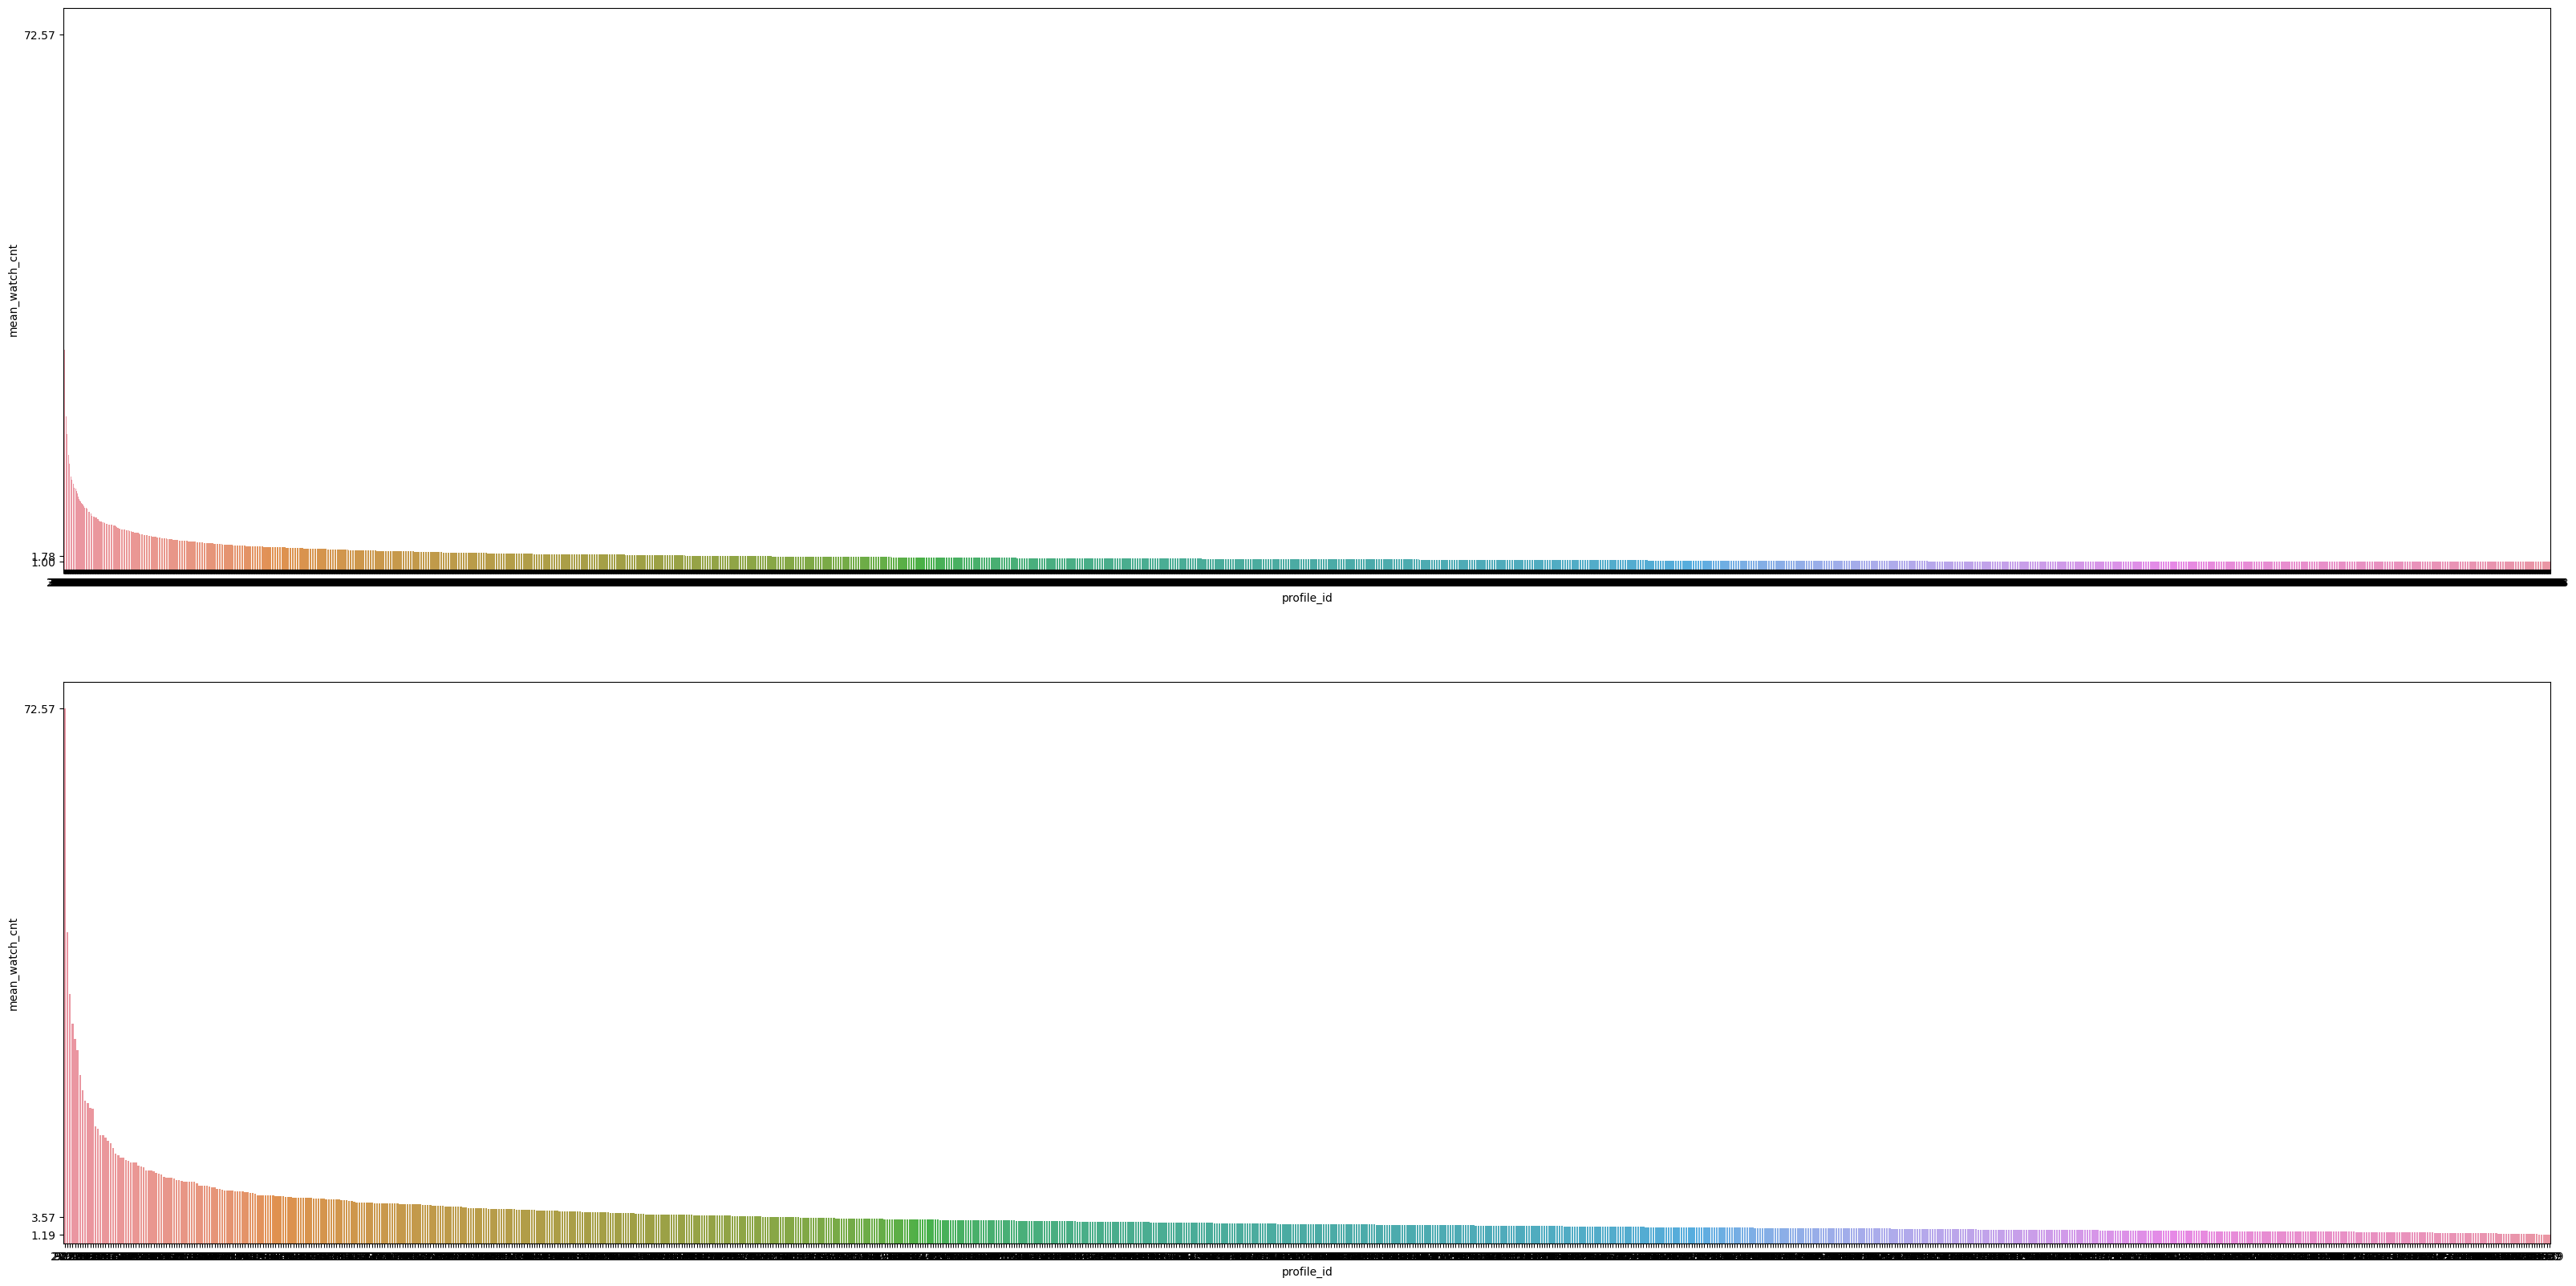

In [170]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(40,20))

plt.subplot(211)
sns.barplot(x='profile_id',y='mean_watch_cnt', data=mean_watch_cnt_df)
plt.yticks(ticks=[mean_watch_cnt_df.mean_watch_cnt.min(),mean_watch_cnt_df.mean_watch_cnt.mean(), mean_watch_cnt_df.mean_watch_cnt.max()])

plt.subplot(212)
sns.barplot(x='profile_id',y='mean_watch_cnt', data=mean_watch_cnt_200up_df)
plt.yticks(ticks=[mean_watch_cnt_200up_df.mean_watch_cnt.min(), mean_watch_cnt_200up_df.mean_watch_cnt.mean(), mean_watch_cnt_200up_df.mean_watch_cnt.max()])

plt.show()

- 200번 이상 시청한 기록이 있는 유저 대상으로 각 유저별 mp 뽑기
- 사실, entropy 로 하는 것이 제일 좋을 것이라고 판단됨 (이후 작업 생각 중)
- 10회 이상 시청한 아이템에 대해서 유저별 mp 뽑기

In [193]:
# user별 아이템 담을 dict 만들기
each_user_mp = {}
for user in payment_mp_pos_df.profile_id.unique():
    each_user_mp[user] = []
    
# 전체 유저 대상 각 유저가 10회 이상 시청 아이템 담기
all_each_user_item_cnt = payment_mp_pos_df.groupby(['profile_id','album_id']).count()['log_time'].reset_index().rename(columns={'log_time':'cnt'})
for idx,row in all_each_user_item_cnt[all_each_user_item_cnt['cnt']>=10].iterrows():
    each_user_mp[row['profile_id']].append(row['album_id'])

In [201]:
# 최종 mp 만듬
each_user_mp

{4783: [7, 364, 370, 2211, 2461, 2728, 7827, 11026],
 25844: [104],
 19024: [],
 5527: [],
 2794: [183,
  228,
  402,
  612,
  703,
  842,
  843,
  844,
  845,
  846,
  847,
  848,
  849,
  850,
  976,
  996,
  999,
  1047,
  1211,
  1212,
  1998,
  1999,
  2641,
  2668,
  2669,
  3501,
  3502],
 20715: [55, 311],
 1790: [],
 19512: [2473],
 25794: [],
 6234: [],
 16213: [],
 16839: [2252, 2253, 2372, 2431, 2502, 3816, 4077, 4235],
 1847: [],
 9294: [],
 21612: [],
 8526: [],
 26441: [15, 16, 19, 38, 224, 410, 3009, 7527, 11670],
 22162: [],
 13774: [],
 23537: [],
 4074: [],
 13839: [],
 5596: [],
 32057: [15,
  16,
  56,
  67,
  81,
  148,
  224,
  265,
  266,
  267,
  406,
  407,
  408,
  1634,
  2296,
  2960,
  5775],
 6420: [241, 428, 542, 2030, 2432, 2433, 2469, 2472, 2589, 2987, 4058],
 20450: [55, 311],
 32193: [],
 15197: [],
 1407: [],
 1279: [7501],
 6202: [16, 1028],
 22738: [16, 67, 105, 241],
 14760: [15, 16, 17, 18, 19, 143, 3564, 3566, 4027, 5555, 6256],
 20710: [124, 2

# buy data & history payment 비교
- 중요사항 확인
- 1. buy 데이터에 없는 payment 기록이 history 있음(전체 구매 데이터가 아닌 것임)
- 2. 유저가 여러차례 중복 구매가능한 것 확인(기간제 컨텐츠로 판단 됨)
- 3. history 데이터에 payment 는 구매후 기간만료전까지는 nan 로 찍히게 됨
- 결론, 학습데이터에 사용은 불가능하지만 purcahse mp100 활용은 할 수 있겠다.
- 이 작업은 위에서 payment_mp100 로 다시 만들어둠

In [20]:
buy_df = pd.read_csv('../../data/buy_data.csv')

In [47]:
# album_id 1640 구매한 유저 3명
list(buy_df[buy_df['album_id']==1640].profile_id)

[1603, 16379, 16379, 16379, 31837]

In [57]:
# 각 유저가 다른 세션에 지불한 것 확인
buy_df[buy_df['album_id']==1640].sort_values(by='ss_id')

,profile_id,ss_id,log_time,act_target_dtl,album_id,payment
1,1603,20220309163919,20220309164043,MKID004,1640,300
117,16379,20220401194916,20220401195721,MKID004,1640,300
123,16379,20220409171403,20220409171439,MKID004,1640,300
129,16379,20220425123026,20220425123506,MKID004,1640,300
148,31837,20220427143436,20220427143618,MKID004,1640,300


In [56]:
# 유저가 아이템을 구매한 후 다시 재시청하면 nan 로 되는 것 확인
# 하지만, 중간에 재구매를 함
# 이를 통해 기간제 컨텐츠이고 이를 재구매하는 경우가 생기게 됨
history[(history['album_id']==1640)&(history['profile_id'].isin(list(buy_df[buy_df['album_id']==1640].profile_id)))].sort_values(by='ss_id')

,profile_id,ss_id,log_time,act_target_dtl,album_id,payment,continuous_play,short_trailer
53067,1603,20220309163919,20220309164046,MKID003,1640,300.0,Y,N
633959,16379,20220401194916,20220401195725,MKID003,1640,300.0,Y,N
633974,16379,20220401194916,20220401201915,MKID003,1640,NaN,Y,N
633975,16379,20220401194916,20220401202017,MKID003,1640,NaN,Y,N
633986,16379,20220401194916,20220401204538,MKID003,1640,NaN,Y,N
633999,16379,20220405135655,20220405135717,MKID003,1640,NaN,Y,N
634005,16379,20220405135655,20220405144246,MKID003,1640,NaN,Y,N
634017,16379,20220407160013,20220407162358,MKID003,1640,NaN,Y,N
634023,16379,20220409171403,20220409172030,MKID003,1640,300.0,N,N
634024,16379,20220409171403,20220409172618,MKID003,1640,300.0,N,N


In [60]:
# 1640 아이템 확인
# 아이들 나라 들어가서 확인해보니 확인 불가 아이템임
all_meta_df[all_meta_df['album_id']==1640]

,album_id,title,sub_title,genre_large,genre_mid,genre_small,country,run_time,onair_date,cast_1,cast_2,cast_3,cast_4,cast_5,cast_6,cast_7,keyword_type,keyword_name
37654,1640,뿡뿡 화장실 숨바꼭질,[핑크퐁 상어가족 숨바꼭질],키즈,노래율동,NaN,한국,338,NaN,핑크퐁,올리,NaN,NaN,NaN,NaN,NaN,"[05010101, 05010202, 05010401, 05010402, 05010...","[시리즈, 2분 이상 10분 미만, 3세, 4세, 1세, 2세, 핑크퐁, 엔터, 사..."
